In [1]:
import torch
import torchvision
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image

from transformers import ViTFeatureExtractor, ViTForImageClassification
#from transformers import BitForImageClassification, BeitConfig, BeitFeatureExtractor, Trainer, TrainingArguments

from PIL import Image

from AutoAugment.autoaugment import ImageNetPolicy

from tqdm import tqdm
from collections import defaultdict, OrderedDict

In [2]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [3]:
df = pd.read_csv("../data/train_labels.csv", names=['img_name', 'label'], header=1)

df = df.append([df[df["label"] == 20]] * 15, ignore_index = True)
df = df.sample(frac=1, random_state = 42).reset_index(drop=True)

df.shape

(31016, 2)

In [4]:
class food_set(Dataset):

    def __init__(self, df, labels_file, img_dir, extractor, transform = None, settype = "train"):
        self.df = df
        if settype == "train":
            self.img_labels = df[:30000]
        elif settype == "val":
            self.img_labels = df[30000:]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
                
        features = self.feature_extractor(images=image, 
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])["pixel_values"][0]      
        
        label = self.img_labels.iloc[idx, 1]       
            
        return features, label

In [5]:
class food_test(Dataset):

    def __init__(self, img_dir, extractor, transform = None):
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)        
        
        if self.transform:
            image = self.transform(image, 
                                  mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
        
        features = self.feature_extractor(images=image)["pixel_values"][0]
        
        return file_name, features

In [12]:
# Load ViT
vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# for param in vit.parameters():
#     param.requires_grad = False

vit.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(768, 384)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(384, 81)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

vit.load_state_dict(torch.load("../../vit_jim.pth"))

vit.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [14]:
def train_loop(trainloader, valloader, model, criterion, optimizer, labels, 
               img_dir, feature_extractor = None, transform = None):
    
    
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    try:
        stats["epoch"].append(0)
        stats["loss"].append(8.7)
        stats["accuracy"].append(1.25)

        size = len(trainloader.dataset)
        
        for epoch in range(9):        
            for batch, (image, label) in enumerate(trainloader):
                # Compute prediction and loss
                image, label = image.to(device), label.to(device)            
                pred = model(image)
                loss = criterion(pred["logits"], label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Print progress
                if batch % 200 == 0:
                    loss, current = loss.item(), batch * len(image)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")

            # Print performance after current number of epochs
            print(f"Epoch: {epoch + 1}")
            current_acc, avg_loss = test_loop(valloader, model, criterion)

            if current_acc > max_acc:
                PATH = f'../../vit_jim.pth'
                torch.save(vit.state_dict(), PATH)
                max_acc = current_acc
            
            # Store metadata
            stats["epoch"].append(epoch + 1)
            stats["accuracy"].append(current_acc)
            stats["loss"].append(avg_loss)

            # Plot progress
            fig, ax1 = plt.subplots()

            color = "tab:blue"
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Loss", color=color)
            ax1.plot(stats["epoch"], stats["loss"], color=color)
            ax1.tick_params(axis="y", labelcolor=color)

            ax2 = ax1.twinx()

            color = "tab:orange"
            ax2.set_ylabel("Accuracy", color=color)
            ax2.plot(stats["epoch"], stats["accuracy"], color=color)
            ax2.tick_params(axis="y", labelcolor=color)
            plt.show()

        return stats
    
    except KeyboardInterrupt:
        return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred["logits"], label).item()
            correct += (pred["logits"].argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

In [23]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vit.parameters(), lr = 0.001, momentum = 0.9)
# optimizer = optim.Adam(vit.parameters(), lr=0.00001)

In [9]:
img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"

train_transforms = transforms.Compose([
                     transforms.RandomApply([transforms.ColorJitter()], p=0.3),
                     transforms.RandomApply([transforms.Grayscale(3)], p=0.3),
                     transforms.RandomApply([transforms.RandomAffine(180)], p=0.3),
                     transforms.RandomHorizontalFlip()])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224)])

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')


In [17]:
trainset = food_set(df, labels, img_dir, feature_extractor, transform = train_transforms, settype = "train")
valset = food_set(df, labels, img_dir, feature_extractor, settype = "val")

# Create a DataLoader with the data
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=16, shuffle=True, num_workers=0)

In [10]:
test_set = food_test("../data/test_set/test_set", feature_extractor)
testloader = DataLoader(test_set, batch_size = 16)

len(test_set)

7653

loss: 4.206789  [    0/30000] epoch: 1
loss: 3.614467  [ 3200/30000] epoch: 1
loss: 2.379006  [ 6400/30000] epoch: 1
loss: 2.039985  [ 9600/30000] epoch: 1
loss: 1.748298  [12800/30000] epoch: 1
loss: 0.998639  [16000/30000] epoch: 1
loss: 1.679800  [19200/30000] epoch: 1
loss: 1.105411  [22400/30000] epoch: 1
loss: 1.992059  [25600/30000] epoch: 1
loss: 1.615246  [28800/30000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 68.6%, Avg loss: 1.225969 



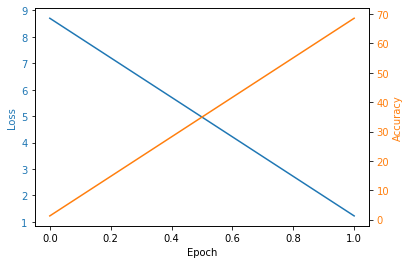

loss: 1.713701  [    0/30000] epoch: 2
loss: 1.233470  [ 3200/30000] epoch: 2
loss: 1.197591  [ 6400/30000] epoch: 2
loss: 0.760708  [ 9600/30000] epoch: 2
loss: 1.411417  [12800/30000] epoch: 2
loss: 1.497653  [16000/30000] epoch: 2
loss: 1.914945  [19200/30000] epoch: 2
loss: 0.516155  [22400/30000] epoch: 2
loss: 1.073180  [25600/30000] epoch: 2
loss: 1.483706  [28800/30000] epoch: 2
Epoch: 2
Test Error: 
 Accuracy: 72.5%, Avg loss: 1.076863 



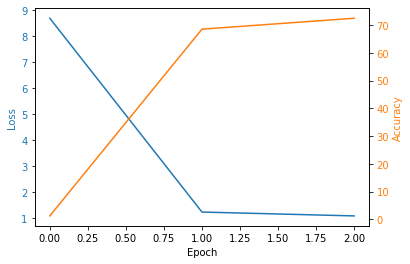

loss: 1.183408  [    0/30000] epoch: 3
loss: 1.506828  [ 3200/30000] epoch: 3
loss: 1.420538  [ 6400/30000] epoch: 3
loss: 1.003771  [ 9600/30000] epoch: 3
loss: 1.396670  [12800/30000] epoch: 3
loss: 1.045694  [16000/30000] epoch: 3
loss: 0.961199  [19200/30000] epoch: 3
loss: 0.398585  [22400/30000] epoch: 3
loss: 0.770174  [25600/30000] epoch: 3
loss: 0.716088  [28800/30000] epoch: 3
Epoch: 3
Test Error: 
 Accuracy: 72.6%, Avg loss: 1.036985 



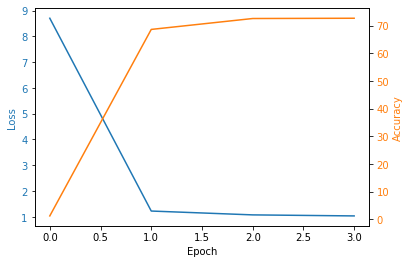

loss: 1.527970  [    0/30000] epoch: 4
loss: 1.324553  [ 3200/30000] epoch: 4
loss: 0.622715  [ 6400/30000] epoch: 4
loss: 1.248795  [ 9600/30000] epoch: 4
loss: 0.932035  [12800/30000] epoch: 4
loss: 0.993649  [16000/30000] epoch: 4
loss: 0.812467  [19200/30000] epoch: 4
loss: 1.480501  [22400/30000] epoch: 4
loss: 1.265867  [25600/30000] epoch: 4
loss: 0.915808  [28800/30000] epoch: 4
Epoch: 4
Test Error: 
 Accuracy: 74.3%, Avg loss: 1.016258 



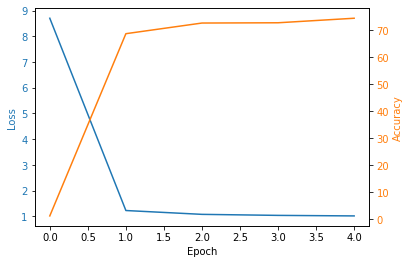

loss: 0.704540  [    0/30000] epoch: 5
loss: 0.868972  [ 3200/30000] epoch: 5
loss: 0.240041  [ 6400/30000] epoch: 5
loss: 0.653021  [ 9600/30000] epoch: 5
loss: 0.372941  [12800/30000] epoch: 5
loss: 0.416726  [16000/30000] epoch: 5
loss: 0.889405  [19200/30000] epoch: 5
loss: 0.818335  [22400/30000] epoch: 5
loss: 0.434505  [25600/30000] epoch: 5
loss: 1.015274  [28800/30000] epoch: 5
Epoch: 5
Test Error: 
 Accuracy: 74.6%, Avg loss: 1.010797 



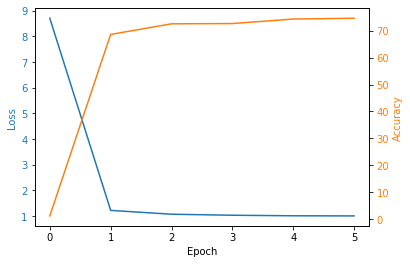

loss: 0.472278  [    0/30000] epoch: 6
loss: 0.441060  [ 3200/30000] epoch: 6
loss: 0.585971  [ 6400/30000] epoch: 6
loss: 0.383287  [ 9600/30000] epoch: 6
loss: 0.176387  [12800/30000] epoch: 6
loss: 0.401234  [16000/30000] epoch: 6
loss: 0.703186  [19200/30000] epoch: 6
loss: 0.782875  [22400/30000] epoch: 6
loss: 0.702764  [25600/30000] epoch: 6
loss: 0.562295  [28800/30000] epoch: 6
Epoch: 6
Test Error: 
 Accuracy: 74.7%, Avg loss: 1.023136 



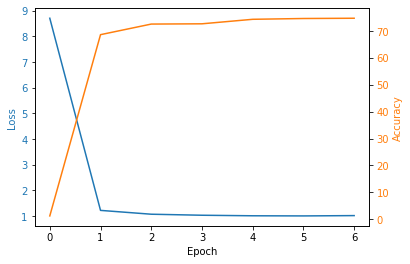

loss: 0.900969  [    0/30000] epoch: 7
loss: 0.332897  [ 3200/30000] epoch: 7
loss: 0.310414  [ 6400/30000] epoch: 7
loss: 0.728232  [ 9600/30000] epoch: 7
loss: 0.414927  [12800/30000] epoch: 7
loss: 0.325669  [16000/30000] epoch: 7
loss: 0.213717  [19200/30000] epoch: 7
loss: 0.296817  [22400/30000] epoch: 7
loss: 0.963042  [25600/30000] epoch: 7
loss: 0.648013  [28800/30000] epoch: 7
Epoch: 7
Test Error: 
 Accuracy: 74.1%, Avg loss: 0.999327 



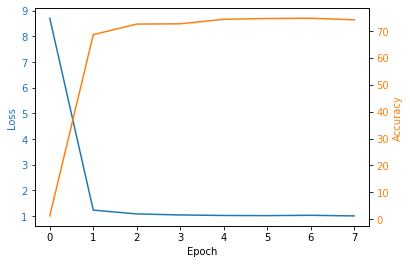

loss: 0.768418  [    0/30000] epoch: 8
loss: 0.388507  [ 3200/30000] epoch: 8
loss: 0.346598  [ 6400/30000] epoch: 8
loss: 0.909542  [ 9600/30000] epoch: 8
loss: 0.810457  [12800/30000] epoch: 8
loss: 0.439388  [16000/30000] epoch: 8
loss: 0.729634  [19200/30000] epoch: 8
loss: 0.692173  [22400/30000] epoch: 8
loss: 0.678934  [25600/30000] epoch: 8
loss: 0.634552  [28800/30000] epoch: 8
Epoch: 8
Test Error: 
 Accuracy: 74.6%, Avg loss: 1.057067 



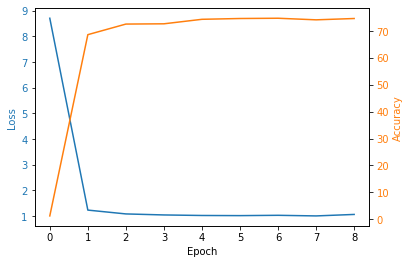

loss: 0.329069  [    0/30000] epoch: 9
loss: 0.575057  [ 3200/30000] epoch: 9
loss: 0.478341  [ 6400/30000] epoch: 9
loss: 0.212113  [ 9600/30000] epoch: 9
loss: 0.376539  [12800/30000] epoch: 9
loss: 0.439342  [16000/30000] epoch: 9
loss: 0.995478  [19200/30000] epoch: 9
loss: 0.771505  [22400/30000] epoch: 9
loss: 0.335359  [25600/30000] epoch: 9
loss: 0.972980  [28800/30000] epoch: 9
Epoch: 9
Test Error: 
 Accuracy: 74.7%, Avg loss: 1.063106 



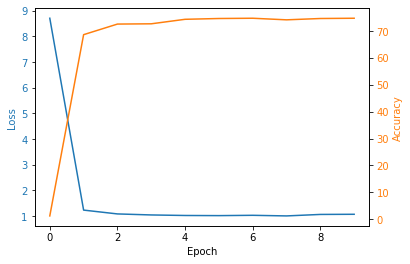

In [25]:
stats = train_loop(trainloader, valloader, vit, criterion, optimizer, 
                   labels, img_dir, feature_extractor)

In [13]:
# PATH = '../../ViT_full_training_10_epochs.pth'
# torch.save(vit.state_dict(), PATH)

# vit.load_state_dict(torch.load("../../ViT_weights.pth"))
# vit.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [26]:
df_stats = pd.DataFrame(stats)
df_stats.to_csv("../../stats_vit_9_epochs.csv")

In [13]:
test_results = defaultdict(list)

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = vit(X)["logits"] # .argmax(1)
    
    for i, img in enumerate(file_name):
        test_results["img"].append(img)        
        for rank, (label, prob) in enumerate(zip(pred.topk(5).values[i], pred.topk(5).indices[i])):
            test_results[rank + 1].append((float(label), int(prob)))

100%|████████████████████████████████████████| 479/479 [03:07<00:00,  2.56it/s]


In [14]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img,1,2,3,4,5
0,test_1.jpg,"(-0.08497627079486847, 15)","(-3.015348434448242, 3)","(-4.831662654876709, 61)","(-4.931093215942383, 28)","(-5.798975467681885, 14)"
1,test_10.jpg,"(-0.02700304426252842, 45)","(-4.2033514976501465, 49)","(-5.633333206176758, 53)","(-5.983034133911133, 28)","(-6.312559604644775, 24)"
2,test_100.jpg,"(-0.9408162236213684, 38)","(-1.514045000076294, 23)","(-2.3015568256378174, 48)","(-2.4833781719207764, 12)","(-3.4959609508514404, 14)"
3,test_1000.jpg,"(-0.153160959482193, 29)","(-2.3765783309936523, 15)","(-3.5185494422912598, 10)","(-4.214999198913574, 37)","(-7.240321636199951, 68)"
4,test_1001.jpg,"(-0.8350465893745422, 10)","(-1.4697439670562744, 29)","(-2.8285129070281982, 37)","(-2.8431832790374756, 18)","(-3.180274724960327, 32)"


In [15]:
# test_df.to_csv("submission_vit_standard.csv", index=False)
test_df.to_csv("../../ensemble_subs/ViT_ensemble_proba.csv", index=False)